## Load in the data
    Since the data is a .db, which is a sqlite database. We will convert the tables to pandas dataframe as required. Since the table sizes arent too big we can use pandas dataframes.

In [1]:
import sqlite3
import pandas as pd

In [2]:
# Read sqlite query results into a pandas DataFrame
sql_conn = sqlite3.connect("sqlite.db")
exec_df = pd.read_sql_query("SELECT * from exec", sql_conn)
sql_conn.close()

In [3]:
exec_df.head()

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [4]:
exec_df[exec_df.docker.notnull()].head()

,ts,exe,pid,ppid,path,docker,depth,rates
82,22.574,crawl.sh,28647,28628,/webcrawl/crawl.sh,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 1.0, ""5"": 0.2}"
83,22.604,python,28668,28647,python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 2.0, ""5"": 0.4}"
84,22.936,python,28669,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 3.0, ""5"": 0.6}"
88,23.374,python,28673,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 4.0, ""5"": 0.8}"
92,24.167,python,28679,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 2.0, ""5"": 1.0}"


We need to split the json in rate column into two seperate columns, 'rate1s' and 'rate5s'.
    1. Use rates column to create a dataframe of 2 columns 'rate1s', 'rate5s'.
    2. Concat the dataframe from step 1 with exec_df to get the final clean dtaframe.

In [5]:
# Split rates column into two columns
rates_df = exec_df['rates'].apply(lambda x : dict(eval(x)) ).apply(pd.Series)
rates_df.columns = ['rate1s', 'rate5s']

In [6]:
rates_df.head()

,rate1s,rate5s
0,1.0,0.2
1,2.0,0.4
2,3.0,0.6
3,1.0,0.8
4,2.0,1.0


In [7]:
# Concat this with exec_df to get the entire dataset
exec_clean = pd.concat([exec_df, rates_df], axis=1)

In [8]:
exec_clean.head()

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}",1.0,0.2
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}",2.0,0.4
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}",3.0,0.6
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}",1.0,0.8
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}",2.0,1.0


# 1. Visualization
    We start of with visualizing our data. Visualization can provide a holistic view of our data, helping us further our understanding of the dataset.
    
    Start of with importing visualization libraries

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

## Plot depth
    What is depth? 

In [10]:
# Numerical distribution of depth
exec_clean['depth'].value_counts()

-1    1709
 5     790
 2       2
 3       1
 4       1
Name: depth, dtype: int64

Looking at the distribution of the data, we can see that this type of data can be easily visualized using a scatter plot

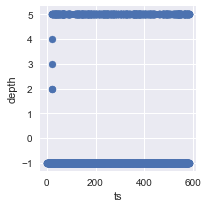

In [11]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "depth")  

In [12]:
exec_clean[(exec_clean.depth >= 2) & (exec_clean.depth <= 4)]

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
67,22.069,auplink,28606,917,/sbin/auplink,None,2,"{""1"": 5.0, ""5"": 3.4}",5.0,3.4
68,22.107,auplink,28607,917,auplink,None,2,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
77,22.221,docker-containe,28628,1051,/usr/bin/docker-containerd-shim,None,3,"{""1"": 15.0, ""5"": 5.4}",15.0,5.4
78,22.228,docker-runc,28633,28628,/usr/bin/docker-runc,None,4,"{""1"": 16.0, ""5"": 5.6}",16.0,5.6


### interesting because all these outliers occur near 22s time, ideal to zoom in on this time scale

(-1, 5)

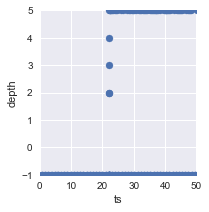

In [13]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "depth")  
plt.xlim(0, 50)  
plt.ylim(-1, 5) 

##### Thoughts
    1. the depth has -1 from the start of time, but at time ~ 22 there are a few depth outliers and then they vanish as time goes by.
    2. The value of '-1' for depth might be just a default value for no docker. Because the depth is '-1' only when docker column is empty.

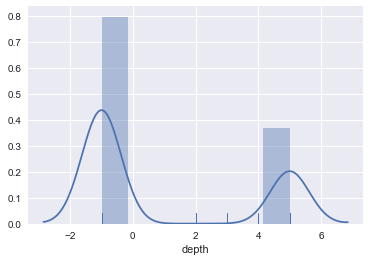

In [14]:
# histogram
sns.distplot(exec_clean['depth'], kde=True, rug=True)

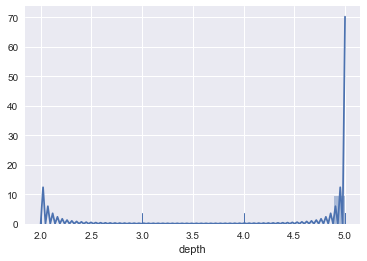

In [15]:
# histogram after removing default depth
sns.distplot(exec_clean[exec_clean.depth != -1]['depth'], kde=True, rug=True)

## Plot Rate1s


In [16]:
# rate1s numerical distribution
exec_clean['rate1s'].value_counts()

3.0     830
2.0     775
1.0     686
4.0     183
5.0      11
17.0      2
16.0      2
6.0       2
18.0      2
8.0       1
7.0       1
19.0      1
9.0       1
11.0      1
12.0      1
13.0      1
14.0      1
15.0      1
10.0      1
Name: rate1s, dtype: int64

In [17]:
exec_clean[(exec_clean.rate1s > 5)].sort_values(by='depth')

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
76,22.199,systemd-sysctl,28624,28614,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 14.0, ""5"": 5.2}",14.0,5.2
86,23.047,sed,28672,28670,sed,None,-1,"{""1"": 17.0, ""5"": 6.0}",17.0,6.0
85,23.035,sh,28670,1158,sh,None,-1,"{""1"": 16.0, ""5"": 5.8}",16.0,5.8
87,23.052,lpstat,28671,28670,/usr/bin/lpstat,None,-1,"{""1"": 18.0, ""5"": 6.2}",18.0,6.2
75,22.188,ifquery,28619,-1,/sbin/ifquery,None,-1,"{""1"": 13.0, ""5"": 5.0}",13.0,5.0
74,22.187,systemd-sysctl,28623,28613,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 12.0, ""5"": 4.8}",12.0,4.8
593,138.300,01ifupdown,29195,29191,/etc/NetworkManager/dispatcher.d/01ifupdown,None,-1,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
72,22.164,ifquery,28622,-1,/sbin/ifquery,None,-1,"{""1"": 10.0, ""5"": 4.4}",10.0,4.4
71,22.159,ifquery,28617,28615,/sbin/ifquery,None,-1,"{""1"": 9.0, ""5"": 4.2}",9.0,4.2
70,22.159,ifquery,28621,-1,/sbin/ifquery,None,-1,"{""1"": 8.0, ""5"": 4.0}",8.0,4.0


Again we see a lot of outliers of rate1s aroung the 22 time, and there is a lot of overlap with depth=-1 values. 
We can see a few outliers from the distribution of rate1s, we can try using scatter plot here as well

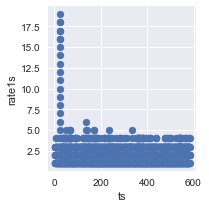

In [18]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate1s")  

Zoom in

(-1, 20)

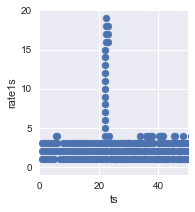

In [19]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate1s")  
plt.xlim(0, 50)  
plt.ylim(-1, 20) 

These outliers occur at around 22t as well.

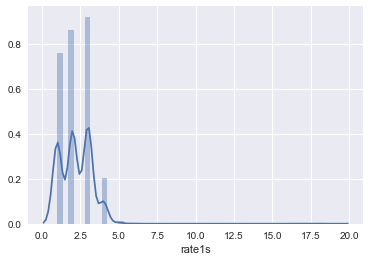

In [20]:
# histogram
sns.distplot(exec_clean['rate1s'], kde=True);

In [21]:
# rate1s numerical distribution
exec_clean['rate5s'].value_counts()

2.8    606
2.6    598
3.0    451
2.4    170
2.0     93
1.6     92
1.8     89
2.2     86
1.4     60
1.2     50
1.0     47
0.8     44
0.6     35
0.4     20
3.2     11
0.2     10
3.4     10
6.2      5
5.8      5
6.0      5
3.6      3
5.2      2
5.4      2
5.6      2
4.2      1
4.6      1
4.4      1
3.8      1
5.0      1
4.0      1
4.8      1
Name: rate5s, dtype: int64

In [22]:
exec_clean[(exec_clean.rate1s > 5)].sort_values(by='depth')

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
76,22.199,systemd-sysctl,28624,28614,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 14.0, ""5"": 5.2}",14.0,5.2
86,23.047,sed,28672,28670,sed,None,-1,"{""1"": 17.0, ""5"": 6.0}",17.0,6.0
85,23.035,sh,28670,1158,sh,None,-1,"{""1"": 16.0, ""5"": 5.8}",16.0,5.8
87,23.052,lpstat,28671,28670,/usr/bin/lpstat,None,-1,"{""1"": 18.0, ""5"": 6.2}",18.0,6.2
75,22.188,ifquery,28619,-1,/sbin/ifquery,None,-1,"{""1"": 13.0, ""5"": 5.0}",13.0,5.0
74,22.187,systemd-sysctl,28623,28613,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 12.0, ""5"": 4.8}",12.0,4.8
593,138.300,01ifupdown,29195,29191,/etc/NetworkManager/dispatcher.d/01ifupdown,None,-1,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
72,22.164,ifquery,28622,-1,/sbin/ifquery,None,-1,"{""1"": 10.0, ""5"": 4.4}",10.0,4.4
71,22.159,ifquery,28617,28615,/sbin/ifquery,None,-1,"{""1"": 9.0, ""5"": 4.2}",9.0,4.2
70,22.159,ifquery,28621,-1,/sbin/ifquery,None,-1,"{""1"": 8.0, ""5"": 4.0}",8.0,4.0


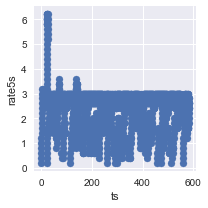

In [23]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate5s")  

(-1, 10)

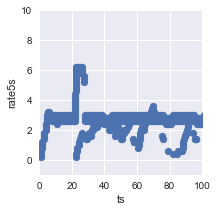

In [24]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate5s")  
plt.xlim(0, 100)  
plt.ylim(-1, 10) 

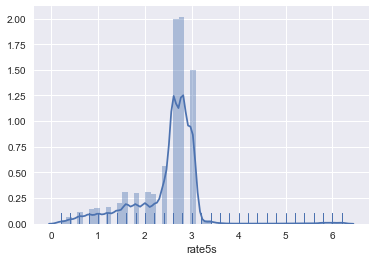

In [25]:
# histogram
sns.distplot(exec_clean['rate5s'], kde=True, rug=True);

### Time scale plot

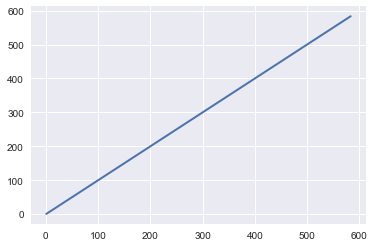

In [26]:
plt.plot(exec_clean['ts'], exec_clean['ts'], linewidth=2)

In [27]:
def display_plot_hist(input_df, x, y, x_lim=0, y_lim=0):
    """
    Function to display a scatter plot and histogram given a dataframe and the corresponding X and Y axis
    
    @Param:
        input_df: the input dataframe
        x: the name of the column to be considered the x axis
        y: the name of the column to be considered the y axis
        x_lim: the x axis limits, pass as list (optional)
        y_lim: the y axis limit, pass as list (optional)
    
    @Return:
        None
    """
    # Display Scatter plot
    plt.figure()
    #g = sns.FacetGrid(input_df)  
    #g.map(plt.scatter, x, y)  
    #fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.lmplot(x, y, data=input_df, fit_reg=False)
    if x_lim != 0:
        plt.xlim(x_lim)  
        plt.ylim(y_lim) 
    # Histogram
    plt.figure()
    sns.distplot(input_df[y], kde=True, rug=True)

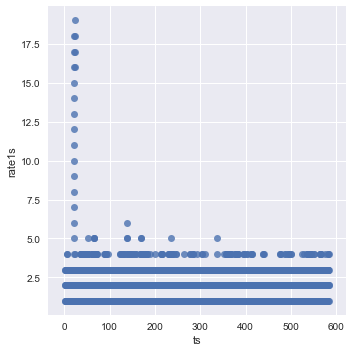

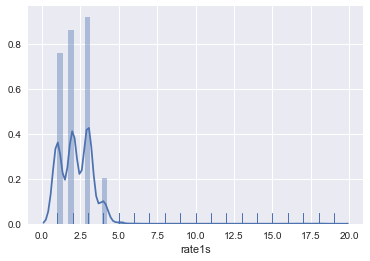

In [28]:
display_plot_hist(input_df=exec_clean, x='ts', y='rate1s')

In [29]:
# Read sqlite query results into a pandas DataFrame
sql_conn = sqlite3.connect("sqlite.db")
tcp_df = pd.read_sql_query("SELECT * from tcplife", sql_conn)
sql_conn.close()

In [30]:
tcp_df.head()

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality
0,25.147065,28668,60290,80,30,0,93.65,"[[0, 0, 1, 0, 0], 93.65, 93.65]","[[0, 0, 1, 0, 0], 30, 30]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.362980,1
1,25.536215,28669,47054,80,166,0,192.11,"[[1, 0, 0, 0, 1], 93.65, 192.11]","[[1, 0, 0, 0, 1], 30, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-14.629130,1
2,26.039532,28673,53762,80,0,0,81.72,"[[2, 0, 0, 0, 1], 81.72, 192.11]","[[2, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.452350,1
3,26.201396,28673,50248,80,0,0,25.16,"[[1, 1, 1, 0, 1], 25.16, 192.11]","[[3, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.414340,1
4,26.329412,28673,57968,443,0,0,17.78,"[[2, 1, 1, 0, 1], 17.78, 192.11]","[[4, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-23.817379,0


##  Plot
       rx, tx, dur, lport and rport

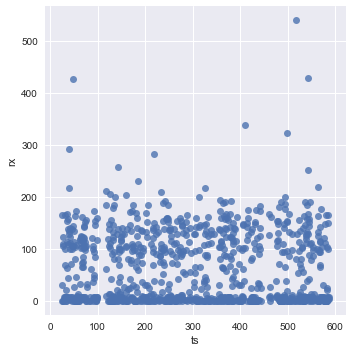

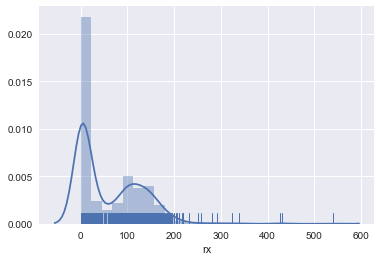

In [31]:
display_plot_hist(input_df=tcp_df, x='ts', y='rx')

In [32]:
tcp_df.count()

ts             944
pid            944
lport          944
rport          944
rx             944
tx             944
dur            944
histotimes     944
histosizes     944
histoports     944
docker         944
prediction     944
predquality    944
dtype: int64

In [33]:
tcp_df['tx'].value_counts()

0    944
Name: tx, dtype: int64

/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


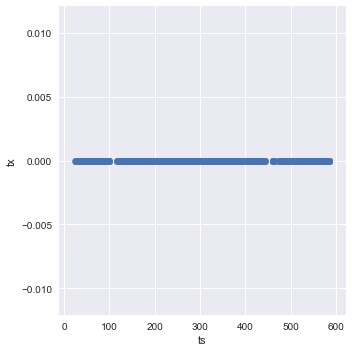

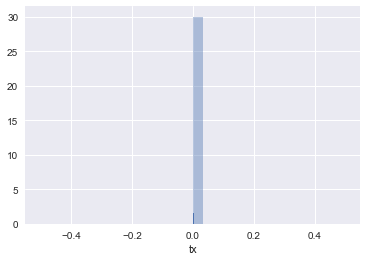

In [34]:
display_plot_hist(input_df=tcp_df, x='ts', y='tx')

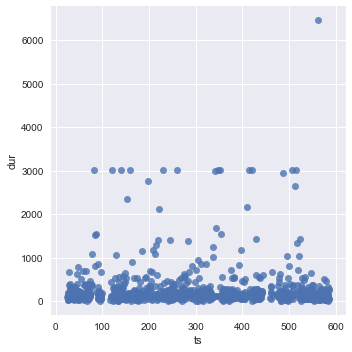

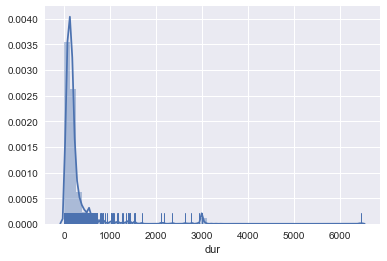

In [35]:
display_plot_hist(input_df=tcp_df, x='ts', y='dur')

In [36]:
tcp_df.describe()

,ts,pid,rx,tx,dur,prediction,predquality
count,944.000000,944.000000,944.000000,944.0,944.000000,944.000000,944.000000
mean,307.715209,29928.452331,61.332627,0.0,261.219121,-15.492141,0.875000
std,171.971029,751.111665,69.228605,0.0,479.331879,23.434887,0.330894
min,25.147065,28668.000000,0.000000,0.0,5.040000,-569.245187,0.000000
25%,157.886505,29267.750000,4.000000,0.0,85.512500,-13.940197,1.000000
50%,307.397860,29935.500000,26.000000,0.0,144.650000,-11.497844,1.000000
75%,462.115531,30601.000000,115.000000,0.0,226.797500,-10.481379,1.000000
max,585.672974,31149.000000,540.000000,0.0,6454.020000,8.375431,1.000000


In [37]:
tcp_df.dtypes

ts             float64
pid              int64
lport           object
rport           object
rx               int64
tx               int64
dur            float64
histotimes      object
histosizes      object
histoports      object
docker          object
prediction     float64
predquality      int64
dtype: object

In [38]:
tcp_df[['lport', 'rport']] = tcp_df[['lport', 'rport']].astype(int)

In [39]:
tcp_df['lport'].value_counts()

60116    2
47232    2
48672    2
44284    2
59954    2
47274    2
33322    2
47270    2
47266    2
48644    2
47796    2
40276    2
48226    2
48346    2
47674    2
48204    2
47358    2
48224    2
47342    2
47110    2
48550    2
48564    2
47236    2
47376    2
47354    2
35204    1
47762    1
47760    1
47734    1
47758    1
        ..
52430    1
48400    1
48404    1
57662    1
46396    1
48376    1
60756    1
40274    1
42320    1
48462    1
36172    1
48452    1
48450    1
48448    1
49706    1
48446    1
48442    1
48406    1
58680    1
49704    1
48438    1
38194    1
34372    1
50474    1
51492    1
46376    1
48418    1
48414    1
48412    1
47106    1
Name: lport, dtype: int64

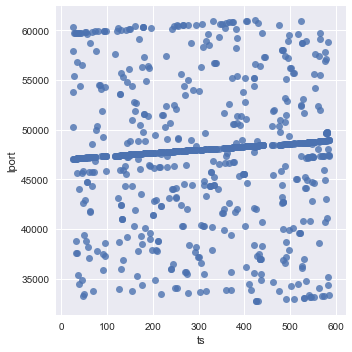

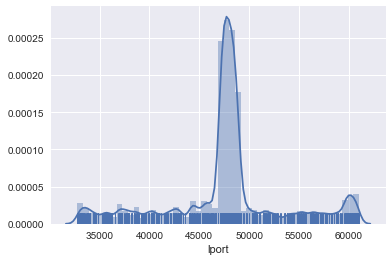

In [40]:
display_plot_hist(input_df=tcp_df, x='ts', y='lport')

In [41]:
tcp_df['rport'].value_counts()

80     833
443    111
Name: rport, dtype: int64

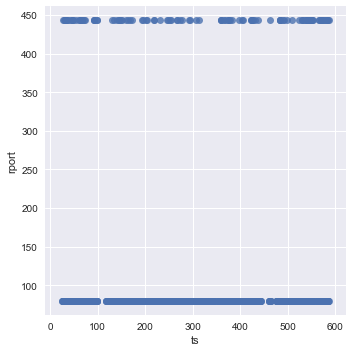

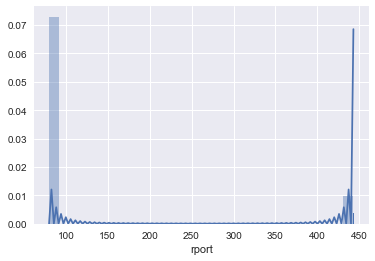

In [42]:
display_plot_hist(input_df=tcp_df, x='ts', y='rport')

# 2. Data Statistics

In [43]:
# Basic descriptive statistics using pandas
tcp_df['dur'].describe().to_dict()

{'25%': 85.512500000000003,
 '50%': 144.64999999999998,
 '75%': 226.79749999999999,
 'count': 944.0,
 'max': 6454.0200000000004,
 'mean': 261.2191207627119,
 'min': 5.04,
 'std': 479.33187947782443}

In [44]:
tcp_df['dur'].var()

229759.05068374358

In [45]:
# getting mean and median for central tendency, we already have mean
# calculate median
tcp_df['dur'].median()

144.64999999999998

In [46]:
# Geometric mean
# central tendency
from scipy.stats.mstats import mode, gmean, hmean
gmean(tcp_df['dur'])

141.50098946061695

In [47]:
# Harmonic Mean, preferable for averaging rates
hmean(tcp_df['dur'])

79.480319918010437

In [48]:
from scipy.stats import trim_mean, mode
trim_mean(tcp_df['dur'], proportiontocut=0.10)

162.62596560846561

In [49]:
mode(tcp_df['dur'])[0][0]

50.920000000000002

In [50]:
from scipy.stats.mstats import mode, gmean, hmean
from scipy.stats import trim_mean, mode
def get_descriptive_stats(input_df, column, trim_mean_proportion=0.10):
    """
    Function to print the descriptive statics of a give dataframe
    
    @Params:
        input_df: the input data frame which contains a column whose descriptive statics is to be calculated
        column: the name of the column whose descriptive statics is to be calculated.
        
    @Returns:
        desc_stat: a dictionary with the descriptive statistics
    """
    KEY_ORDER = ['count', 'min', 'max', 'mean', 'geometricmean', 'harmonicmean', 'trimmedmean', 'median','mode', 'std', 'variance', '25%', '50%', '75%']
    desc_stat = {}
    desc_stat = input_df[column].describe().to_dict()
    desc_stat['variance'] = input_df[column].var()
    desc_stat['median'] = input_df[column].median()
    desc_stat['geometricmean'] = gmean(input_df[column])
    desc_stat['harmonicmean'] = hmean(input_df[column])
    desc_stat['trimmedmean'] = trim_mean(input_df[column], proportiontocut=trim_mean_proportion)
    desc_stat['mode'] = mode(input_df[column])[0][0]
    print('---------------------DESCRIPTIVE STATICS---------------------')
    for key in KEY_ORDER:
        print(key +': '+str(desc_stat[key]) )
    print('-------------------------------------------------------------')
    return desc_stat

In [51]:
desc_stat = get_descriptive_stats(tcp_df, 'dur')

---------------------DESCRIPTIVE STATICS---------------------
count: 944.0
min: 5.04
max: 6454.02
mean: 261.219120763
geometricmean: 141.500989461
harmonicmean: 79.480319918
trimmedmean: 162.625965608
median: 144.64999999999998
mode: 50.92
std: 479.331879478
variance: 229759.05068374358
25%: 85.5125
50%: 144.65
75%: 226.7975
-------------------------------------------------------------


In [52]:
tcp_df.head().sort_values(by='docker')

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality
0,25.147065,28668,60290,80,30,0,93.65,"[[0, 0, 1, 0, 0], 93.65, 93.65]","[[0, 0, 1, 0, 0], 30, 30]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.362980,1
1,25.536215,28669,47054,80,166,0,192.11,"[[1, 0, 0, 0, 1], 93.65, 192.11]","[[1, 0, 0, 0, 1], 30, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-14.629130,1
2,26.039532,28673,53762,80,0,0,81.72,"[[2, 0, 0, 0, 1], 81.72, 192.11]","[[2, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.452350,1
3,26.201396,28673,50248,80,0,0,25.16,"[[1, 1, 1, 0, 1], 25.16, 192.11]","[[3, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.414340,1
4,26.329412,28673,57968,443,0,0,17.78,"[[2, 1, 1, 0, 1], 17.78, 192.11]","[[4, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-23.817379,0


## Anomalous values of 'dur'
    first we can look at its visualization again.
    

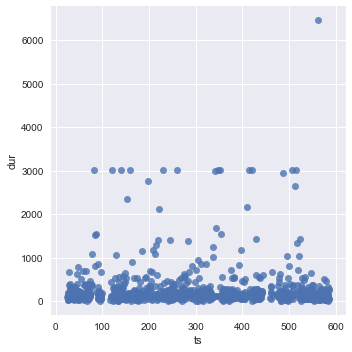

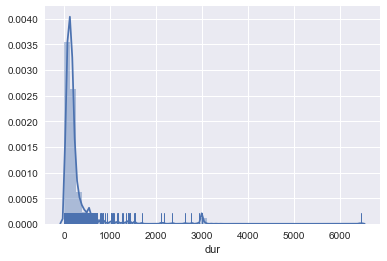

In [53]:
display_plot_hist(input_df=tcp_df, x='ts', y='dur')

From insepecting the visualization using the eye we can see one data point that seems anamolous, but we need to be sure that it is an anamolous data point using statistics.
    this looks like a poisson distribution.

In [54]:
tcp_df['dur'].value_counts()

3003.39    2
86.62      2
127.26     2
154.29     2
167.84     2
128.81     2
241.97     2
50.92      2
183.93     1
91.72      1
182.10     1
2640.32    1
100.36     1
100.05     1
120.45     1
253.55     1
83.05      1
109.69     1
160.10     1
154.31     1
92.95      1
98.06      1
36.40      1
317.37     1
118.99     1
96.86      1
45.81      1
172.62     1
108.63     1
118.37     1
          ..
135.65     1
76.21      1
445.51     1
379.25     1
107.60     1
158.65     1
114.92     1
45.05      1
44.05      1
859.04     1
110.94     1
188.20     1
96.10      1
172.66     1
42.64      1
90.86      1
37.05      1
7.40       1
85.85      1
456.62     1
143.37     1
169.23     1
80.52      1
129.24     1
26.03      1
161.24     1
179.63     1
355.54     1
712.09     1
120.00     1
Name: dur, dtype: int64

In [55]:
tcp_df[tcp_df.docker == 'None'].head()

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality


## Check for anomalies in 'dur' data:

    First we need to define what anomaly is for the 'dur' variable, since we do not know what 'dur' variable really, represents we cannot remove any outliers. From the Data Modelling question we can infer that 'dur' represents a time series data.
     Assumption is that 'dur' represents a duration of some process or event.
 
    1. MAD approach
    2. Moving MAD approach
    

## Distance from mean in terms of Standard Deviation:

In [56]:
desc_stat = get_descriptive_stats(tcp_df, 'dur')

---------------------DESCRIPTIVE STATICS---------------------
count: 944.0
min: 5.04
max: 6454.02
mean: 261.219120763
geometricmean: 141.500989461
harmonicmean: 79.480319918
trimmedmean: 162.625965608
median: 144.64999999999998
mode: 50.92
std: 479.331879478
variance: 229759.05068374358
25%: 85.5125
50%: 144.65
75%: 226.7975
-------------------------------------------------------------


In [57]:
#distance from mean in terms of standard deviation
tcp_df['dur_dist_from_mean'] = abs((tcp_df['dur'] - desc_stat['mean']) / desc_stat['std'])

In [58]:
tcp_df.head()

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality,dur_dist_from_mean
0,25.147065,28668,60290,80,30,0,93.65,"[[0, 0, 1, 0, 0], 93.65, 93.65]","[[0, 0, 1, 0, 0], 30, 30]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.362980,1,0.349589
1,25.536215,28669,47054,80,166,0,192.11,"[[1, 0, 0, 0, 1], 93.65, 192.11]","[[1, 0, 0, 0, 1], 30, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-14.629130,1,0.144178
2,26.039532,28673,53762,80,0,0,81.72,"[[2, 0, 0, 0, 1], 81.72, 192.11]","[[2, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.452350,1,0.374478
3,26.201396,28673,50248,80,0,0,25.16,"[[1, 1, 1, 0, 1], 25.16, 192.11]","[[3, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.414340,1,0.492475
4,26.329412,28673,57968,443,0,0,17.78,"[[2, 1, 1, 0, 1], 17.78, 192.11]","[[4, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-23.817379,0,0.507872


## Windowing approach:
    Here we operate under the assumption that there is little noise and there are no seasonal fluctuations with 'dur' variable.
    1. mean
    2. median
  

In [59]:
# moving mean average using python
tcp_df['rolling_mean'] =tcp_df.rolling(window=5, on='ts').mean()['dur']
tcp_df['rolling_median'] =tcp_df.rolling(window=5, on='ts').median()['dur']
# tcp_df.rolling(window=5, on='ts').median()

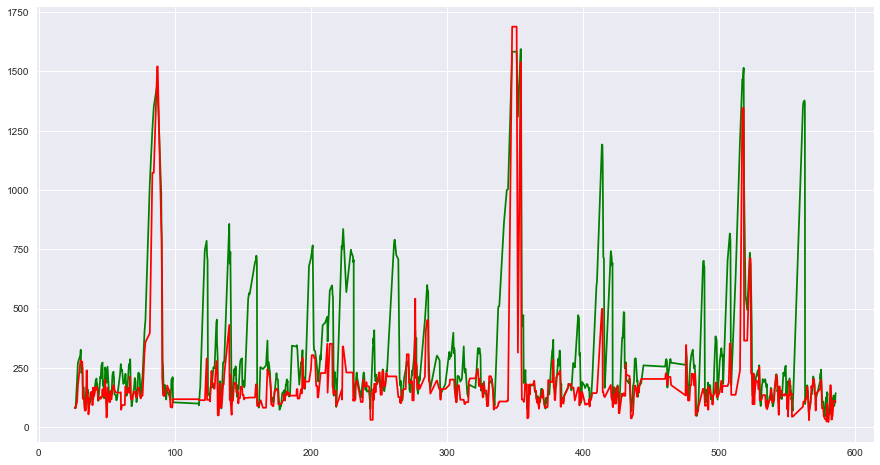

In [60]:
# Plot moving average
plt.figure(figsize=(15, 8))
#plt.plot(tcp_df['ts'], tcp_df['rolling_mean'], "k.")
plt.plot(tcp_df['ts'], tcp_df['rolling_mean'], color='green')
plt.plot(tcp_df['ts'], tcp_df['rolling_median'], color='red')

## Lets try MAD (Median Absolute Deviation)

In [61]:
# Rolling Mean absolute deviation, reference: https://www.geogebra.org/m/UaMEvgyH
win_size = 5 
tcp_df['MAD'] = (tcp_df['dur'] - tcp_df.rolling(window=win_size, on='ts').mean()['dur'])/ win_size

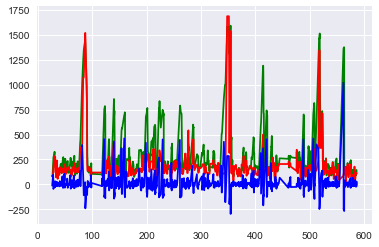

In [62]:
plt.plot(tcp_df['ts'], tcp_df['rolling_mean'], color='green')
plt.plot(tcp_df['ts'], tcp_df['rolling_median'], color='red')
plt.plot(tcp_df['ts'], tcp_df['MAD'], color='blue')

In [63]:
# Calculate modified z score, reference: http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
tcp_df['mod_z_score'] = 0.6745 * (tcp_df['dur'] - tcp_df['rolling_median']) / tcp_df['MAD']

In [64]:
# Z score > 3.5 can be potential outliers
tcp_df
#['mod_z_score']

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality,dur_dist_from_mean,rolling_mean,rolling_median,MAD,mod_z_score
0,25.147065,28668,60290,80,30,0,93.65,"[[0, 0, 1, 0, 0], 93.65, 93.65]","[[0, 0, 1, 0, 0], 30, 30]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.362980,1,0.349589,NaN,NaN,NaN,NaN
1,25.536215,28669,47054,80,166,0,192.11,"[[1, 0, 0, 0, 1], 93.65, 192.11]","[[1, 0, 0, 0, 1], 30, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-14.629130,1,0.144178,NaN,NaN,NaN,NaN
2,26.039532,28673,53762,80,0,0,81.72,"[[2, 0, 0, 0, 1], 81.72, 192.11]","[[2, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.452350,1,0.374478,NaN,NaN,NaN,NaN
3,26.201396,28673,50248,80,0,0,25.16,"[[1, 1, 1, 0, 1], 25.16, 192.11]","[[3, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.414340,1,0.492475,NaN,NaN,NaN,NaN
4,26.329412,28673,57968,443,0,0,17.78,"[[2, 1, 1, 0, 1], 17.78, 192.11]","[[4, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-23.817379,0,0.507872,82.084,81.72,-12.8608,3.353410
5,26.635802,28679,47062,80,109,0,107.94,"[[2, 1, 2, 0, 1], 17.78, 192.11]","[[4, 0, 0, 1, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.667371,1,0.319777,84.942,81.72,4.5996,3.844984
6,26.941862,28680,47064,80,105,0,172.62,"[[2, 1, 2, 0, 2], 17.78, 192.11]","[[4, 0, 0, 2, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.390430,1,0.184839,81.044,81.72,18.3152,3.347605
7,28.057589,28681,55366,80,123,0,677.68,"[[5, 2, 0, 0, 1], 17.78, 677.68]","[[4, 0, 0, 3, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-15.920145,1,0.868836,200.236,107.94,95.4888,4.024447
8,28.587030,28685,47068,80,4,0,360.14,"[[5, 2, 1, 0, 1], 17.78, 677.68]","[[5, 0, 0, 3, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.187297,1,0.206372,267.232,172.62,18.5816,6.806854
9,28.634554,28685,59690,443,7,0,38.43,"[[6, 2, 1, 0, 1], 17.78, 677.68]","[[6, 0, 0, 3, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 2, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-25.866711,0,0.464791,271.362,172.62,-46.5864,1.942866


## Try Modified z score outlier detection without any moving windows
reference: https://colingorrie.github.io/outlier-detection.html

In [65]:
tcp_df['median'] = tcp_df['dur'].median()

In [66]:
tcp_df['mean_abs_deviation'] = tcp_df['dur'].mad()

In [67]:
tcp_df['modified_z_scores'] = 0.6745 * (tcp_df['dur'] - tcp_df['median']) / tcp_df['mean_abs_deviation']

In [68]:
tcp_df['mad_anomalies'] = 0

In [69]:
threshold = 3.5

In [70]:
tcp_df['mad_anomalies'] = [1 if abs(x) > threshold else 0 for x in tcp_df['modified_z_scores']]

In [71]:
tcp_df['mad_anomalies'].value_counts()

0    914
1     30
Name: mad_anomalies, dtype: int64

In [72]:
ts_anomaly = tcp_df[tcp_df.mad_anomalies == 1]['ts']
dur_anomaly = tcp_df[tcp_df.mad_anomalies == 1]['dur']

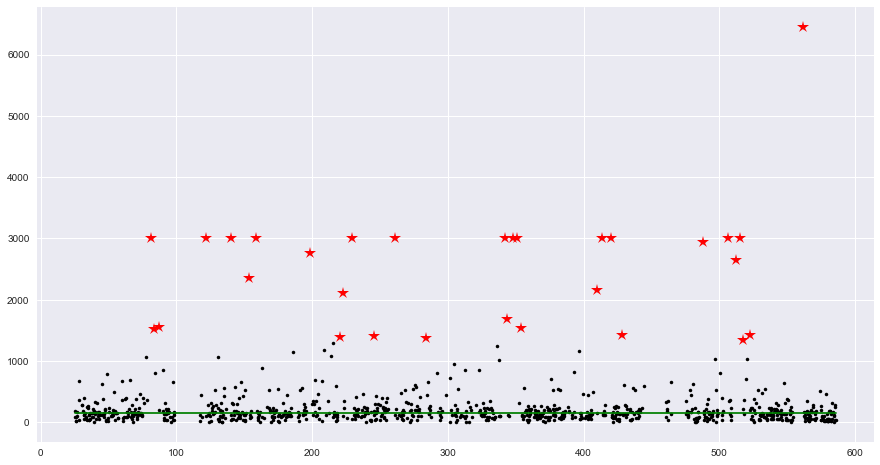

In [73]:
plt.figure(figsize=(15, 8))
plt.plot(tcp_df['ts'], tcp_df['dur'], "k.")
plt.plot(tcp_df['ts'], tcp_df['median'], color='green')
#plt.plot(tcp_df['ts'], tcp_df['dur'].mean(), color='blue')
plt.plot(ts_anomaly, dur_anomaly, "r*", markersize=12)
#plt.xlabel(text_xlabel)
#plt.ylabel(text_ylabel)

The above seems good, but it doesnt account for the seasonal fluctuations. More knowledge required about the data to interpret the above plot

## Try Modified z score outlier detection with moving windows
    for this we need to calculate moving median and moving MAD

In [74]:
threshold = 3.5
win_size = 20

In [79]:
import numpy as np
mad = lambda x: np.fabs(x - x.mean()).mean()

In [80]:
tcp_df['rolling_median'] =tcp_df.rolling(window=win_size, on='ts').median()['dur']
tcp_df['rolling_mad'] = tcp_df.rolling(window=win_size, on='ts').apply(mad)['dur']

In [81]:
tcp_df['rolling_modified_z_scores'] = 0.6745 * (tcp_df['dur'] - tcp_df['rolling_median']) / tcp_df['rolling_mad']

In [82]:
tcp_df['rolling_mad_anomalies'] = [1 if abs(x) > threshold else 0 for x in tcp_df['rolling_modified_z_scores']]
ts_r_anomaly = tcp_df[tcp_df.rolling_mad_anomalies == 1]['ts']
dur_r_anomaly = tcp_df[tcp_df.rolling_mad_anomalies == 1]['dur']

In [83]:
tcp_df[tcp_df.rolling_modified_z_scores > 2]['rolling_modified_z_scores']

50     3.862333
60     3.252783
70     2.048950
79     2.611803
93     2.583495
116    3.094136
123    2.158160
125    4.291526
127    5.675144
128    2.153456
151    2.674948
159    2.122993
161    6.019912
198    6.229949
219    2.614256
231    5.208104
236    4.018943
278    2.464297
289    5.151582
305    5.003624
325    2.281114
337    2.194188
338    2.727585
343    3.154943
374    5.561348
402    6.794687
427    2.373618
429    2.224947
441    3.901336
463    2.806157
         ...   
520    2.048689
523    2.794322
524    2.271010
583    4.092470
584    2.171354
595    2.019021
615    4.267713
618    4.407936
640    2.726888
641    5.523057
643    4.289532
650    2.948159
672    5.969030
702    2.461887
709    2.520861
723    2.050182
737    5.754508
760    5.017631
767    2.469044
773    4.980268
780    3.298154
781    2.714494
809    2.046831
814    2.088434
836    2.376250
854    3.956906
874    7.109884
904    3.237841
916    2.371614
934    2.079011
Name: rolling_modified_z

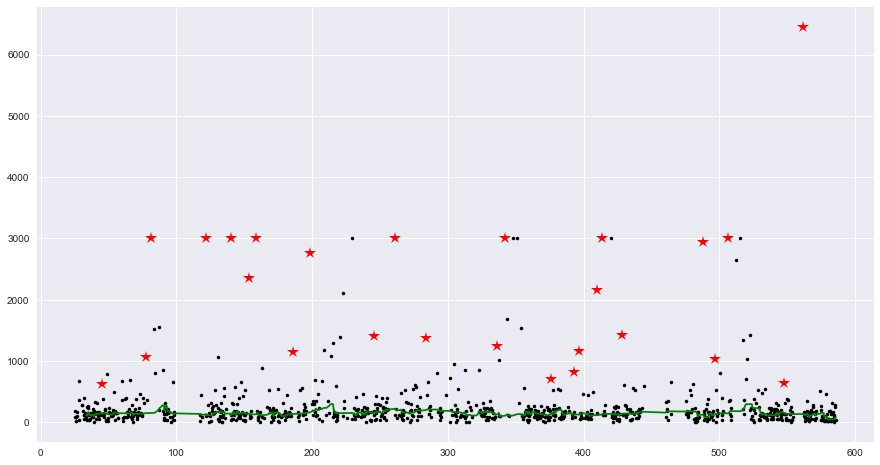

In [84]:
plt.figure(figsize=(15, 8))
plt.plot(tcp_df['ts'], tcp_df['dur'], "k.")
plt.plot(tcp_df['ts'], tcp_df['rolling_median'], color='green')
#plt.plot(tcp_df['ts'], tcp_df['dur'].mean(), color='blue')
plt.plot(ts_r_anomaly, dur_r_anomaly, "r*", markersize=12)

We can see as we increase the window size the results begin to resemble the diagram which did not use moving MAD.

## Time Series Prediction

### Checks for the time series to be stationary:
    1. Look at plots
    2. summary statistics
    3. Statistical test
 
reference: http://machinelearningmastery.com/time-series-data-stationary-python/

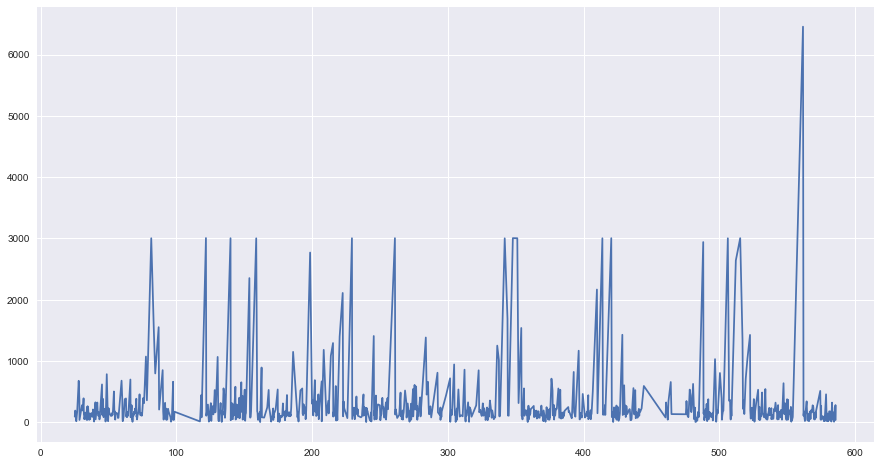

In [85]:
# plots
# plot dur vs ts
plt.figure(figsize=(15, 8))
plt.plot(tcp_df['ts'], tcp_df['dur'])

Looks stationary with some outliers

## Summary statistics:
    We can split up the dataset and check if their mean and variance differ a lot.

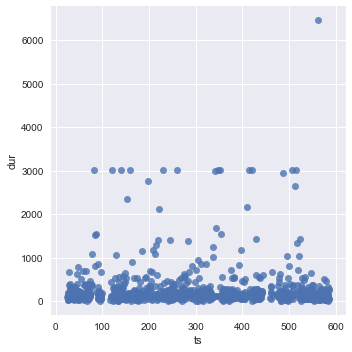

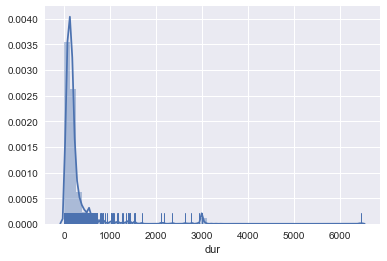

In [86]:
# summary statistics
display_plot_hist(input_df=tcp_df, x='ts', y='dur')

In [91]:
tcp_df.shape

(944, 25)

In [92]:
944/2

472.0

In [98]:
df1 = tcp_df.iloc[:472, :]
df2 = tcp_df.iloc[472:, :]

In [102]:
df2.head()

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,...,rolling_median,MAD,mod_z_score,median,mean_abs_deviation,modified_z_scores,mad_anomalies,rolling_mad,rolling_modified_z_scores,rolling_mad_anomalies
472,307.766799,29936,47996,80,159,0,536.13,"[[436, 22, 6, 2, 7], 5.04, 3006.16]","[[277, 173, 19, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 54, ""80...",...,169.025,63.8636,3.794984,144.65,222.753156,1.185407,0,173.19700,1.429657,0
473,308.727679,29940,58352,80,0,0,94.00,"[[437, 22, 6, 2, 7], 5.04, 3006.16]","[[278, 173, 19, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 54, ""80...",...,160.280,-24.1020,2.317457,144.65,222.753156,-0.153369,0,176.73625,-0.252952,0
474,309.778312,29940,40316,80,0,0,116.13,"[[438, 22, 6, 2, 7], 5.04, 3006.16]","[[279, 173, 19, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 54, ""80...",...,160.280,-15.3132,-0.000000,144.65,222.753156,-0.086359,0,174.86025,-0.170303,0
475,310.928347,29940,40318,80,0,0,98.28,"[[439, 22, 6, 2, 7], 5.04, 3006.16]","[[280, 173, 19, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 54, ""80...",...,140.285,-21.1980,0.567970,144.65,222.753156,-0.140409,0,176.43425,-0.160583,0
476,312.278612,29940,44434,443,199,0,859.04,"[[439, 23, 6, 2, 7], 5.04, 3006.16]","[[280, 173, 20, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",...,168.065,103.6648,4.833780,144.65,222.753156,2.163184,0,215.77570,2.159940,0


In [100]:
desc_stat = get_descriptive_stats(df1, 'dur')

---------------------DESCRIPTIVE STATICS---------------------
count: 472.0
min: 5.04
max: 3006.16
mean: 263.370995763
geometricmean: 148.671959358
harmonicmean: 80.5404857736
trimmedmean: 174.201746032
median: 151.745
mode: 5.04
std: 424.764741932
variance: 180425.08598817835
25%: 93.755
50%: 151.745
75%: 239.67
-------------------------------------------------------------


In [101]:
desc_stat = get_descriptive_stats(df2, 'dur')

---------------------DESCRIPTIVE STATICS---------------------
count: 472.0
min: 5.79
max: 6454.02
mean: 259.067245763
geometricmean: 134.675900586
harmonicmean: 78.4477016768
trimmedmean: 151.296587302
median: 135.79000000000002
mode: 50.92
std: 528.745255991
variance: 279571.5457325256
25%: 78.7075
50%: 135.79
75%: 212.7275
-------------------------------------------------------------


The statistics for these 2 datasets look the same.
Their histograms looks the same as well

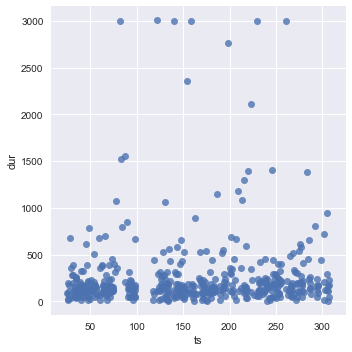

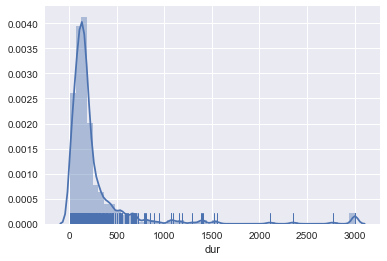

In [103]:
display_plot_hist(input_df=df1, x='ts', y='dur')

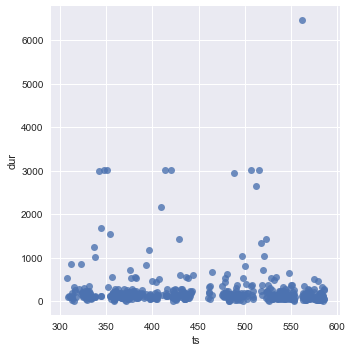

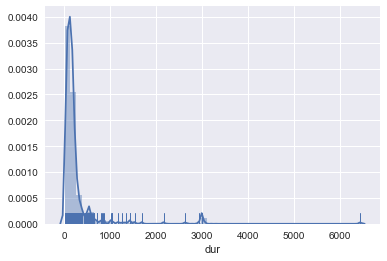

In [104]:
display_plot_hist(input_df=df2, x='ts', y='dur')

## Dickey fuller test
    the dickey fuller test is a type of unit root test. This helps to determine if a time series data is defined by a trend.
    It is a kind of hypothesis test
        1. H0 null hypothesis: the time series is non stationary
        2. Ha alternate hypothesis: the time series is stationary
       We use p value with an alpha of 0.05

In [108]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
result = adfuller(tcp_df['dur'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.252495
p-value: 0.000000
Critical Values:
	5%: -2.865
	10%: -2.568
	1%: -3.437


In [111]:
from pandas import Series
from statsmodels.tsa.stattools import kpss
result = kpss(tcp_df['dur'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.069269
p-value: 0.100000
Critical Values:
	5%: 0.463
	10%: 0.347
	2.5%: 0.574
	1%: 0.739


/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Time series prediction:

The steps of this project that we will through are as follows.

    Environment.
    Problem Description.
    Test Harness.
    Persistence.
    Data Analysis.
    ARIMA Models.
    Model Validation.
    
ref: http://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

Environment and problem description have been defined already